<a href="https://colab.research.google.com/github/ersilia-os/ersilia-intro-workshop/blob/main/notebooks/m3_hdac1_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train an AI model

This notebook contains the basic steps to train a classifier for bioactivity prediction.

It is prepared to run on Google Colaboratory, if you want to run it locally make sure to create a conda environment with Python 3.10 and install the packages indicated below.

_Remember that the ! sign indicates a bash command, to run it in the terminal simply copy the command without !_

# Supervised Machine Learning

Uses previously **labeled** data to train an algorithm (i.e the output is known). The algorithm learns if it is doing right by comparing the predicted vs the real output.

Simplified steps:
1. Data collection and processing.
2. Division of training data in Train and Test sets.
3. Use the train set to train the model.
4. Predict an output for the test set and compare the predicted vs real results.
5. Improve the model until we are satisfied with the performance on the test set

## Types of supervised ML models
### Classification
Classification problems are characterized by having categorical output (i.e: active, inactive), so the model tries to predict to which class the input belongs. It can include several classes, is not limited to a binary classification.

### Regression
Regression problems are characterized by continuous variables, where the model tries to predict the exact value of the input (i.e: IC50 of a specific compound)

## Evaluation of supervised ML models

### Classification metrics

We obtain the following data to evaluate the model:
- Y_pred: predictions on the test set
- Y_real: real outcome of the test set

**Accuracy:** number of correct predictions divided by the total number of predictions (TP/(lenY)). For example, if we have predicted correctly 5 out of 10 data points --> Accuracy = 50%

**Precision**: identification of only real positives (with a 100% precision, a model does not classify any negatives as positive) --> TP/(TP+FP)

**Recall**: identification of all positives (with a 100% recall, no positive is classified as negative, but some negatives might be included in the positives) --> TP / (TP+FN)

**Confusion matrix**: plots the real vs the predicted values in a table, to easily obtain the FP, TP, TN, FN values.


### Regression metrics
In a regression task, we obtain as error the difference between the predicted value and the real value (i.e: IC50real=0.1, IC50pred = 0.5 --> error of 0.4).


**Mean Absolute Error:** mean of the absolute values of errors.

**Mean Squared Error:** mean of the square error. By squaring, larger errors are contributing more and therefore the model punishes them.

**Root Mean Squared Error:** root of the mean of square error to simplify interpretation (by using MSE, we also square the units which makes them difficult to interpret).

**R-square**: coefficient of determination, the amount of variance explained by the model (from 0 to 1, the closer to 1, the better our model is)

## 1. Install the necessary packages

For this exercise, we will need the following packages:
- RdKit: provides basic chemoinformatics tools
- Pandas: deals with tabular data (like csv files)
- Matplotlib and seaborn: plotting tools to visualise results
- LazyQSAR: a simple package to build fast AI models developed by Ersilia. LazyQSAR automatically installs RdKit, Scikit-Learn, Ersilia Compound Embeddings, FLAML, Mordred and Numpy among others

Google Colab already provides Pandas, Matplotlib and Seaborn pre-installed, so you do not need to install them. If you run this notebook locally please make sure to use the `pip install` command on the Terminal to get the packages in your conda environment

**If you restart the notebook, you will need to reinstall the packages. In a local environment, you do NOT need to reinstall the packages, just activate the conda environment again**

In [45]:
# Package installation
!pip install lazyqsar==0.3

## 2. Load your data

Next, we will use the pandas package to load the training data. At the bare minimmum, you should have a .csv file with two columns: SMILES and Activity of the molecule against the desired target.

In Google Colab, go to the left hand side of the screen and click on the `folder` icon. There, you will see a `Upload file` icon to add your files to the Cloud. You can also call them from Google Drive. These files will be deleted if the notebook is closed, so you will need to re-upload them every time.

If you are working locally, just make sure to input the right path to your data file.

In [76]:
# @title File Name
filename = "hdac1.csv" # @param {type:"string"}


In [77]:
# Load data into a Pandas DataFrame (df)
# We will use the read_csv function from Pandas to automatically upload the csv file in the right format for Python
# We need first to import the package Pandas, which we abbreviate as pd

import pandas as pd

df = pd.read_csv(filename)

In [78]:
# we can now observe how our dataframe looks like
df

,Molecule ChEMBL ID,SMILES,pIC50
0,CHEMBL100035,C/C(=C\c1ccc(NS(=O)(=O)c2ccccc2)cc1)C(=O)NO,5.70
1,CHEMBL1076794,Cc1ccccc1NC(=O)CCCCC(=O)NO,6.24
2,CHEMBL1076939,COc1cc(-n2cc(-c3cccc(NC(=O)CCCCCCC(=O)NO)c3)nn...,8.30
3,CHEMBL1080580,Cc1ccc(NC(=O)c2ccc(/C=C/C(=O)NO)cc2)cc1Nc1nc(-...,7.10
4,CHEMBL1082955,O=C(CCCCCNC(=O)NC(=O)c1ccc(-c2cncnc2)cc1)NO,6.29
...,...,...,...
5799,CHEMBL99398,Nc1ccccc1NC(=O)CCCCCN1C(=O)c2cccc3cc(O)cc(c23)...,6.00
5800,CHEMBL99456,O=C(CCCCCCC(=O)c1ccc(-c2ccc(Br)cc2)cc1)NO,8.70
5801,CHEMBL99671,COc1ccc(C(=O)CCCCCCC(=O)Nc2ccccc2N)cc1,5.30
5802,CHEMBL99810,O=C(CCCCCCCC(=O)c1ccccc1)NO,6.87


In [79]:
# and its shape
df.shape

(5804, 3)

In [80]:
# Let's get the variables right!
# If the column name changes, you need to change these variables
# Remember Python strings are case-sensitive
SMILES = "SMILES"
EXP = "pIC50"
BIN = "bin"

## 3. Define a cut-off

Since we will create a classifier, we need to decide at which cut-off we consider our molecules `Active` or `Inactive`.

We can visualise our data with a histogram for example to make the decision, or we can ask the original data producers for their expert recommendation.

In [81]:
# We import the plotting package Matplotlib, abbreviated as plt
import matplotlib.pyplot as plt

# We select the variable we want to plot in the histogram, in this case the activity values
x = df[EXP] #here you need to write the exact column name, respecting Caps
print(x)

0       5.70
1       6.24
2       8.30
3       7.10
4       6.29
        ... 
5799    6.00
5800    8.70
5801    5.30
5802    6.87
5803    8.02
Name: pIC50, Length: 5804, dtype: float64


(array([1.000e+00, 1.650e+02, 6.280e+02, 1.023e+03, 1.286e+03, 1.301e+03,
        8.590e+02, 3.700e+02, 1.480e+02, 2.300e+01]),
 array([ 3.2 ,  3.91,  4.62,  5.33,  6.04,  6.75,  7.46,  8.17,  8.88,
         9.59, 10.3 ]),
 <BarContainer object of 10 artists>)

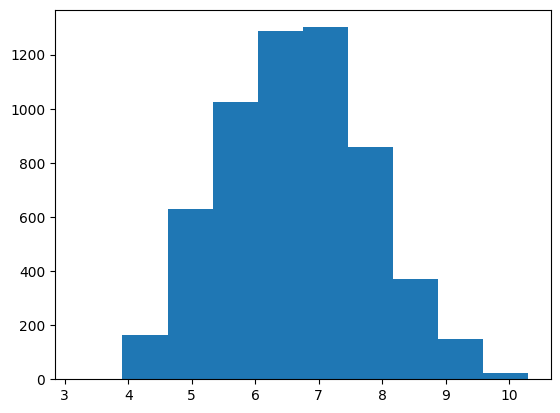

In [82]:
# We now plot the data using the histogram function
plt.hist(x)

Text(0, 0.5, 'Number of mols')

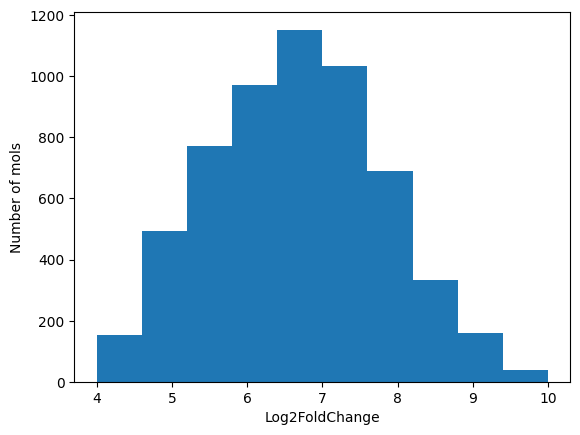

In [83]:
# Depending on our data, we might want to improve the plot for better visualization
# here, we clip the maximmum values to 20
plt.hist(x, range=(4, 10))
plt.xlabel("Log2FoldChange")
plt.ylabel("Number of mols")

To identify the best activity cut-off for your data, you need to:
- Understand the experimental set up: what kind of assay was done? what is the units of activity measured?
- Understand what is the end goal for the model: is it obtaining the most active compounds? Is it to filter our some non-actives to reduce the test number?
- Ask the experts! Talk to the people who ran the experiment, if possible

Once you have the cut-off, transform the activities to binary. Typically, by consensus:
- 1: Active (the compound perturbs our biological system)
- 0: Inactive (the compound does not affect our biolgical system)

In [84]:
# @title Activity cut-off { display-mode: "form" }
# We identify a good cut-off for our data and assign the variable cutoff
cutoff = 7 # @param {type:"number"}

In [85]:
# @title Direction of activity { display-mode: "form" }
# Are our actives lower than the cut-off, or higher than the cut-off?
direction = "higher" # @param {type:"string"}

In [86]:
# Here, we will create a new column in our file with the binary activity

if direction == "lower":
    df[BIN] = [1 if x <= cutoff else 0 for x in df[EXP]]
elif direction == "higher":
    df[BIN] = [1 if x >= cutoff else 0 for x in df[EXP]]
else:
    print("no direction specified. Please select lower or higher direction for the activity cut-off")

In [87]:
# Let's check the output
df

,Molecule ChEMBL ID,SMILES,pIC50,bin
0,CHEMBL100035,C/C(=C\c1ccc(NS(=O)(=O)c2ccccc2)cc1)C(=O)NO,5.70,0
1,CHEMBL1076794,Cc1ccccc1NC(=O)CCCCC(=O)NO,6.24,0
2,CHEMBL1076939,COc1cc(-n2cc(-c3cccc(NC(=O)CCCCCCC(=O)NO)c3)nn...,8.30,1
3,CHEMBL1080580,Cc1ccc(NC(=O)c2ccc(/C=C/C(=O)NO)cc2)cc1Nc1nc(-...,7.10,1
4,CHEMBL1082955,O=C(CCCCCNC(=O)NC(=O)c1ccc(-c2cncnc2)cc1)NO,6.29,0
...,...,...,...,...
5799,CHEMBL99398,Nc1ccccc1NC(=O)CCCCCN1C(=O)c2cccc3cc(O)cc(c23)...,6.00,0
5800,CHEMBL99456,O=C(CCCCCCC(=O)c1ccc(-c2ccc(Br)cc2)cc1)NO,8.70,1
5801,CHEMBL99671,COc1ccc(C(=O)CCCCCCC(=O)Nc2ccccc2N)cc1,5.30,0
5802,CHEMBL99810,O=C(CCCCCCCC(=O)c1ccccc1)NO,6.87,0


In [88]:
# We can print how many actives / inactives we have in our dataset
print("Total molecules: ", len(df))
print("Active molecules: ", len(df[df[BIN]==1]))
print("Inactive molecules: ", len(df[df[BIN]==0]))
print("Frequency of Actives (%): ", len(df[df[BIN]==1])/len(df)*100)

Total molecules:  5804
Active molecules:  2260
Inactive molecules:  3544
Frequency of Actives (%):  38.938662991040665


## 4. Divide the data into Train and Test sets

To make sure our model will have good performance, we need to keep part of the data as a test set, to evaluate the model once trained.

Typically, it is good practice to reserve ~20% of the data as test set. Make sure that the balance of actives / inactives is maintained both in the train and the test sets.

We will try a 5-fold cross-validation (run 5 times random train-test split sets and evaluate the different model performances)

In [89]:
# We will use this function to split the data
# The function uses the sklearn train_test_split built-in method
from sklearn.model_selection import train_test_split
import numpy as np

def random_split(df, size):
    indices = np.arange(len(df))
    X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(df[SMILES], df[EXP], indices, test_size=size, stratify=df[BIN])
    train = df.iloc[i_train]
    test = df.iloc[i_test]
    return train, test

In [90]:
for i in range(5):
    train, test = random_split(df, 0.2)
    train.to_csv("train_set_{}.csv".format(i), index=False)
    test.to_csv("test_set_{}.csv".format(i), index=False)

In [91]:
# We can make sure the active / inactive balance was preserved
train_balance = len(train[train[BIN]==1])/len(train)*100
test_balance = len(test[test[BIN]==1])/len(test)*100

print("The frequency of Actives in the train set is: ", train_balance)
print("The frequency of Actives in the test set is: ", test_balance)

The frequency of Actives in the train set is:  38.940340297221624
The frequency of Actives in the test set is:  38.93195521102498


_* We have individually created the descriptors so that we can check how they look like. Luckily, LazyQSAR provides a single funtion to convert the smiles to vectors and train an ML model, so we will use that feature_

## 6. Train an ML model & get the predictions with Morgan Fingerprints

We have our input (morgan descriptors) and the endpoint, the activity in binary format (1 or 0) so we are ready to train a classifier!
We will use the built-in method in LazyQSAR

In [92]:
import lazyqsar as lq

for i in range(5):
    train = pd.read_csv("train_set_{}.csv".format(i))
    test = pd.read_csv("test_set_{}.csv".format(i))
    smiles_train = train[SMILES]
    y_train = train[BIN]
    model = lq.MorganBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(train[SMILES], train[BIN])
    y_hat = model.predict_proba(test[SMILES])
    test["proba1"] = y_hat[:,1]
    test.to_csv("test_set_pred_morgan_{}.csv".format(i))

[flaml.automl.logger: 09-26 15:06:31] {1679} INFO - task = classification
[flaml.automl.logger: 09-26 15:06:31] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 09-26 15:06:31] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 09-26 15:06:31] {1900} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost']
[flaml.automl.logger: 09-26 15:06:31] {2218} INFO - iteration 0, current learner rf
[flaml.automl.logger: 09-26 15:06:31] {2344} INFO - Estimated sufficient time budget=841s. Estimated necessary time budget=1s.
[flaml.automl.logger: 09-26 15:06:31] {2391} INFO -  at 0.2s,	estimator rf's best error=0.3128,	best estimator rf's best error=0.3128
[flaml.automl.logger: 09-26 15:06:31] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 09-26 15:06:31] {2391} INFO -  at 0.6s,	estimator lgbm's best error=0.3114,	best estimator lgbm's best error=0.3114
[flaml.automl.logger: 09-26 15:06:31] {2218} INFO - iteration 2, current learn

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:06:32] {2391} INFO -  at 1.3s,	estimator xgboost's best error=0.3114,	best estimator lgbm's best error=0.3114
[flaml.automl.logger: 09-26 15:06:32] {2218} INFO - iteration 3, current learner rf
[flaml.automl.logger: 09-26 15:06:32] {2391} INFO -  at 1.4s,	estimator rf's best error=0.2436,	best estimator rf's best error=0.2436
[flaml.automl.logger: 09-26 15:06:32] {2218} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 09-26 15:06:33] {2391} INFO -  at 1.8s,	estimator lgbm's best error=0.3114,	best estimator rf's best error=0.2436
[flaml.automl.logger: 09-26 15:06:33] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 09-26 15:06:33] {2391} INFO -  at 1.8s,	estimator rf's best error=0.2436,	best estimator rf's best error=0.2436
[flaml.automl.logger: 09-26 15:06:33] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 09-26 15:06:33] {2391} INFO -  at 2.0s,	estimator rf's best error=0.2142,	best estimator rf's b

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:06:35] {2391} INFO -  at 4.6s,	estimator xgboost's best error=0.3114,	best estimator rf's best error=0.1219
[flaml.automl.logger: 09-26 15:06:35] {2218} INFO - iteration 17, current learner rf
[flaml.automl.logger: 09-26 15:06:36] {2391} INFO -  at 5.1s,	estimator rf's best error=0.1214,	best estimator rf's best error=0.1214
[flaml.automl.logger: 09-26 15:06:36] {2218} INFO - iteration 18, current learner lgbm
[flaml.automl.logger: 09-26 15:06:36] {2391} INFO -  at 5.5s,	estimator lgbm's best error=0.1796,	best estimator rf's best error=0.1214
[flaml.automl.logger: 09-26 15:06:36] {2218} INFO - iteration 19, current learner lgbm
[flaml.automl.logger: 09-26 15:06:37] {2391} INFO -  at 5.9s,	estimator lgbm's best error=0.1796,	best estimator rf's best error=0.1214
[flaml.automl.logger: 09-26 15:06:37] {2218} INFO - iteration 20, current learner lgbm
[flaml.automl.logger: 09-26 15:06:37] {2391} INFO -  at 6.3s,	estimator lgbm's best error=0.1796,	best estima

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:06:39] {2391} INFO -  at 8.1s,	estimator xgboost's best error=0.2808,	best estimator rf's best error=0.1024
[flaml.automl.logger: 09-26 15:06:39] {2218} INFO - iteration 25, current learner rf
[flaml.automl.logger: 09-26 15:06:39] {2391} INFO -  at 8.7s,	estimator rf's best error=0.0963,	best estimator rf's best error=0.0963
[flaml.automl.logger: 09-26 15:06:39] {2218} INFO - iteration 26, current learner rf
[flaml.automl.logger: 09-26 15:06:40] {2391} INFO -  at 9.5s,	estimator rf's best error=0.0963,	best estimator rf's best error=0.0963
[flaml.automl.logger: 09-26 15:06:40] {2218} INFO - iteration 27, current learner lgbm
[flaml.automl.logger: 09-26 15:06:46] {2391} INFO -  at 14.8s,	estimator lgbm's best error=0.1796,	best estimator rf's best error=0.0963
[flaml.automl.logger: 09-26 15:06:46] {2218} INFO - iteration 28, current learner rf
[flaml.automl.logger: 09-26 15:06:46] {2391} INFO -  at 15.4s,	estimator rf's best error=0.0963,	best estimator rf

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:06:50] {2391} INFO -  at 19.5s,	estimator xgboost's best error=0.2394,	best estimator rf's best error=0.0889
[flaml.automl.logger: 09-26 15:06:50] {2218} INFO - iteration 33, current learner rf
[flaml.automl.logger: 09-26 15:06:52] {2391} INFO -  at 20.8s,	estimator rf's best error=0.0827,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:06:52] {2218} INFO - iteration 34, current learner rf
[flaml.automl.logger: 09-26 15:06:53] {2391} INFO -  at 22.0s,	estimator rf's best error=0.0827,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:06:53] {2218} INFO - iteration 35, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:06:55] {2391} INFO -  at 24.3s,	estimator xgboost's best error=0.2095,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:06:55] {2218} INFO - iteration 36, current learner rf
[flaml.automl.logger: 09-26 15:06:58] {2391} INFO -  at 27.7s,	estimator rf's best error=0.0827,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:06:58] {2218} INFO - iteration 37, current learner lgbm
[flaml.automl.logger: 09-26 15:06:59] {2391} INFO -  at 28.3s,	estimator lgbm's best error=0.1603,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:06:59] {2218} INFO - iteration 38, current learner rf
[flaml.automl.logger: 09-26 15:07:01] {2391} INFO -  at 29.9s,	estimator rf's best error=0.0827,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:07:01] {2218} INFO - iteration 39, current learner rf
[flaml.automl.logger: 09-26 15:07:02] {2391} INFO -  at 31.6s,	estimator rf's best error=0.0827,	best estimator

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:07:04] {2391} INFO -  at 33.0s,	estimator xgboost's best error=0.2095,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:07:04] {2218} INFO - iteration 41, current learner rf
[flaml.automl.logger: 09-26 15:07:07] {2391} INFO -  at 36.0s,	estimator rf's best error=0.0827,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:07:07] {2218} INFO - iteration 42, current learner lgbm
[flaml.automl.logger: 09-26 15:07:07] {2391} INFO -  at 36.5s,	estimator lgbm's best error=0.1603,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:07:07] {2218} INFO - iteration 43, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:07:10] {2391} INFO -  at 39.1s,	estimator xgboost's best error=0.1763,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:07:10] {2218} INFO - iteration 44, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:07:12] {2391} INFO -  at 41.6s,	estimator xgboost's best error=0.1739,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:07:12] {2218} INFO - iteration 45, current learner rf
[flaml.automl.logger: 09-26 15:07:16] {2391} INFO -  at 45.0s,	estimator rf's best error=0.0827,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:07:16] {2218} INFO - iteration 46, current learner lgbm
[flaml.automl.logger: 09-26 15:07:16] {2391} INFO -  at 45.6s,	estimator lgbm's best error=0.0998,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:07:16] {2218} INFO - iteration 47, current learner lgbm
[flaml.automl.logger: 09-26 15:07:17] {2391} INFO -  at 46.4s,	estimator lgbm's best error=0.0896,	best estimator rf's best error=0.0827
[flaml.automl.logger: 09-26 15:07:17] {2218} INFO - iteration 48, current learner lgbm
[flaml.automl.logger: 09-26 15:07:18] {2391} INFO -  at 47.0s,	estimator lgbm's best error=0.0896,	best e

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:07:37] {2391} INFO -  at 2.1s,	estimator xgboost's best error=0.3260,	best estimator rf's best error=0.2985
[flaml.automl.logger: 09-26 15:07:37] {2218} INFO - iteration 3, current learner rf
[flaml.automl.logger: 09-26 15:07:37] {2391} INFO -  at 2.3s,	estimator rf's best error=0.2984,	best estimator rf's best error=0.2984
[flaml.automl.logger: 09-26 15:07:37] {2218} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 09-26 15:07:40] {2391} INFO -  at 4.6s,	estimator lgbm's best error=0.3221,	best estimator rf's best error=0.2984
[flaml.automl.logger: 09-26 15:07:40] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 09-26 15:07:40] {2391} INFO -  at 4.7s,	estimator rf's best error=0.2984,	best estimator rf's best error=0.2984
[flaml.automl.logger: 09-26 15:07:40] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 09-26 15:07:40] {2391} INFO -  at 4.9s,	estimator rf's best error=0.2583,	best estimator rf's bes

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:07:44] {2391} INFO -  at 8.5s,	estimator xgboost's best error=0.3260,	best estimator rf's best error=0.1453
[flaml.automl.logger: 09-26 15:07:44] {2218} INFO - iteration 15, current learner rf
[flaml.automl.logger: 09-26 15:07:44] {2391} INFO -  at 9.0s,	estimator rf's best error=0.1453,	best estimator rf's best error=0.1453
[flaml.automl.logger: 09-26 15:07:44] {2218} INFO - iteration 16, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:07:45] {2391} INFO -  at 9.7s,	estimator xgboost's best error=0.2653,	best estimator rf's best error=0.1453
[flaml.automl.logger: 09-26 15:07:45] {2218} INFO - iteration 17, current learner rf
[flaml.automl.logger: 09-26 15:07:46] {2391} INFO -  at 11.0s,	estimator rf's best error=0.1277,	best estimator rf's best error=0.1277
[flaml.automl.logger: 09-26 15:07:46] {2218} INFO - iteration 18, current learner rf
[flaml.automl.logger: 09-26 15:07:47] {2391} INFO -  at 11.8s,	estimator rf's best error=0.1200,	best estimator rf's best error=0.1200
[flaml.automl.logger: 09-26 15:07:47] {2218} INFO - iteration 19, current learner rf
[flaml.automl.logger: 09-26 15:07:48] {2391} INFO -  at 13.1s,	estimator rf's best error=0.1200,	best estimator rf's best error=0.1200
[flaml.automl.logger: 09-26 15:07:48] {2218} INFO - iteration 20, current learner rf
[flaml.automl.logger: 09-26 15:07:49] {2391} INFO -  at 13.9s,	estimator rf's best error=0.0952,	best estimator rf's

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:07:52] {2391} INFO -  at 16.8s,	estimator xgboost's best error=0.2653,	best estimator rf's best error=0.0952
[flaml.automl.logger: 09-26 15:07:52] {2218} INFO - iteration 24, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:07:53] {2391} INFO -  at 18.3s,	estimator xgboost's best error=0.2653,	best estimator rf's best error=0.0952
[flaml.automl.logger: 09-26 15:07:53] {2218} INFO - iteration 25, current learner rf
[flaml.automl.logger: 09-26 15:07:56] {2391} INFO -  at 20.8s,	estimator rf's best error=0.0911,	best estimator rf's best error=0.0911
[flaml.automl.logger: 09-26 15:07:56] {2218} INFO - iteration 26, current learner rf
[flaml.automl.logger: 09-26 15:08:02] {2391} INFO -  at 26.6s,	estimator rf's best error=0.0911,	best estimator rf's best error=0.0911
[flaml.automl.logger: 09-26 15:08:02] {2218} INFO - iteration 27, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:03] {2391} INFO -  at 28.2s,	estimator xgboost's best error=0.2653,	best estimator rf's best error=0.0911
[flaml.automl.logger: 09-26 15:08:03] {2218} INFO - iteration 28, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:06] {2391} INFO -  at 31.1s,	estimator xgboost's best error=0.2152,	best estimator rf's best error=0.0911
[flaml.automl.logger: 09-26 15:08:06] {2218} INFO - iteration 29, current learner rf
[flaml.automl.logger: 09-26 15:08:08] {2391} INFO -  at 33.0s,	estimator rf's best error=0.0911,	best estimator rf's best error=0.0911
[flaml.automl.logger: 09-26 15:08:08] {2218} INFO - iteration 30, current learner rf
[flaml.automl.logger: 09-26 15:08:13] {2391} INFO -  at 37.6s,	estimator rf's best error=0.0911,	best estimator rf's best error=0.0911
[flaml.automl.logger: 09-26 15:08:13] {2218} INFO - iteration 31, current learner rf
[flaml.automl.logger: 09-26 15:08:15] {2391} INFO -  at 40.1s,	estimator rf's best error=0.0911,	best estimator rf's best error=0.0911
[flaml.automl.logger: 09-26 15:08:15] {2218} INFO - iteration 32, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:17] {2391} INFO -  at 42.2s,	estimator xgboost's best error=0.1656,	best estimator rf's best error=0.0911
[flaml.automl.logger: 09-26 15:08:17] {2218} INFO - iteration 33, current learner rf
[flaml.automl.logger: 09-26 15:08:22] {2391} INFO -  at 47.2s,	estimator rf's best error=0.0903,	best estimator rf's best error=0.0903
[flaml.automl.logger: 09-26 15:08:22] {2218} INFO - iteration 34, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:24] {2391} INFO -  at 48.5s,	estimator xgboost's best error=0.1656,	best estimator rf's best error=0.0903
[flaml.automl.logger: 09-26 15:08:24] {2218} INFO - iteration 35, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:24] {2391} INFO -  at 49.4s,	estimator xgboost's best error=0.1211,	best estimator rf's best error=0.0903
[flaml.automl.logger: 09-26 15:08:24] {2218} INFO - iteration 36, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:25] {2391} INFO -  at 50.2s,	estimator xgboost's best error=0.1211,	best estimator rf's best error=0.0903
[flaml.automl.logger: 09-26 15:08:25] {2218} INFO - iteration 37, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:26] {2391} INFO -  at 50.9s,	estimator xgboost's best error=0.1211,	best estimator rf's best error=0.0903
[flaml.automl.logger: 09-26 15:08:26] {2218} INFO - iteration 38, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:27] {2391} INFO -  at 52.0s,	estimator xgboost's best error=0.1052,	best estimator rf's best error=0.0903
[flaml.automl.logger: 09-26 15:08:27] {2218} INFO - iteration 39, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:28] {2391} INFO -  at 52.9s,	estimator xgboost's best error=0.1052,	best estimator rf's best error=0.0903
[flaml.automl.logger: 09-26 15:08:28] {2218} INFO - iteration 40, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:30] {2391} INFO -  at 54.5s,	estimator xgboost's best error=0.1038,	best estimator rf's best error=0.0903
[flaml.automl.logger: 09-26 15:08:30] {2218} INFO - iteration 41, current learner rf
[flaml.automl.logger: 09-26 15:08:32] {2391} INFO -  at 56.6s,	estimator rf's best error=0.0874,	best estimator rf's best error=0.0874
[flaml.automl.logger: 09-26 15:08:32] {2218} INFO - iteration 42, current learner rf
[flaml.automl.logger: 09-26 15:08:33] {2391} INFO -  at 58.3s,	estimator rf's best error=0.0874,	best estimator rf's best error=0.0874
[flaml.automl.logger: 09-26 15:08:33] {2218} INFO - iteration 43, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:35] {2391} INFO -  at 59.5s,	estimator xgboost's best error=0.1038,	best estimator rf's best error=0.0874
[flaml.automl.logger: 09-26 15:08:39] {2627} INFO - retrain rf for 4.0s
[flaml.automl.logger: 09-26 15:08:39] {2630} INFO - retrained model: RandomForestClassifier(criterion='entropy', max_features=0.07067313856160069,
                       max_leaf_nodes=109, n_estimators=33, n_jobs=-1,
                       random_state=12032022)
[flaml.automl.logger: 09-26 15:08:39] {1930} INFO - fit succeeded
[flaml.automl.logger: 09-26 15:08:39] {1931} INFO - Time taken to find the best model: 56.625821352005005
[flaml.automl.logger: 09-26 15:08:44] {1679} INFO - task = classification
[flaml.automl.logger: 09-26 15:08:44] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 09-26 15:08:44] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 09-26 15:08:44] {1900} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost']

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:45] {2391} INFO -  at 1.2s,	estimator xgboost's best error=0.3418,	best estimator xgboost's best error=0.3418
[flaml.automl.logger: 09-26 15:08:45] {2218} INFO - iteration 3, current learner rf
[flaml.automl.logger: 09-26 15:08:45] {2391} INFO -  at 1.3s,	estimator rf's best error=0.3231,	best estimator rf's best error=0.3231
[flaml.automl.logger: 09-26 15:08:45] {2218} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 09-26 15:08:46] {2391} INFO -  at 1.7s,	estimator lgbm's best error=0.3419,	best estimator rf's best error=0.3231
[flaml.automl.logger: 09-26 15:08:46] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 09-26 15:08:46] {2391} INFO -  at 1.8s,	estimator rf's best error=0.3231,	best estimator rf's best error=0.3231
[flaml.automl.logger: 09-26 15:08:46] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 09-26 15:08:46] {2391} INFO -  at 2.0s,	estimator rf's best error=0.3136,	best estimator rf'

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:50] {2391} INFO -  at 5.6s,	estimator xgboost's best error=0.3418,	best estimator rf's best error=0.2158
[flaml.automl.logger: 09-26 15:08:50] {2218} INFO - iteration 15, current learner rf
[flaml.automl.logger: 09-26 15:08:50] {2391} INFO -  at 6.2s,	estimator rf's best error=0.1577,	best estimator rf's best error=0.1577
[flaml.automl.logger: 09-26 15:08:50] {2218} INFO - iteration 16, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:08:52] {2391} INFO -  at 8.0s,	estimator xgboost's best error=0.3026,	best estimator rf's best error=0.1577
[flaml.automl.logger: 09-26 15:08:52] {2218} INFO - iteration 17, current learner rf
[flaml.automl.logger: 09-26 15:08:53] {2391} INFO -  at 8.4s,	estimator rf's best error=0.1577,	best estimator rf's best error=0.1577
[flaml.automl.logger: 09-26 15:08:53] {2218} INFO - iteration 18, current learner rf
[flaml.automl.logger: 09-26 15:08:53] {2391} INFO -  at 9.1s,	estimator rf's best error=0.1339,	best estimator rf's best error=0.1339
[flaml.automl.logger: 09-26 15:08:53] {2218} INFO - iteration 19, current learner rf
[flaml.automl.logger: 09-26 15:08:54] {2391} INFO -  at 9.6s,	estimator rf's best error=0.1339,	best estimator rf's best error=0.1339
[flaml.automl.logger: 09-26 15:08:54] {2218} INFO - iteration 20, current learner rf
[flaml.automl.logger: 09-26 15:08:55] {2391} INFO -  at 10.9s,	estimator rf's best error=0.1339,	best estimator rf's be

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:09:01] {2391} INFO -  at 16.4s,	estimator xgboost's best error=0.2933,	best estimator rf's best error=0.1164
[flaml.automl.logger: 09-26 15:09:01] {2218} INFO - iteration 25, current learner rf
[flaml.automl.logger: 09-26 15:09:01] {2391} INFO -  at 16.8s,	estimator rf's best error=0.1164,	best estimator rf's best error=0.1164
[flaml.automl.logger: 09-26 15:09:01] {2218} INFO - iteration 26, current learner rf
[flaml.automl.logger: 09-26 15:09:03] {2391} INFO -  at 18.9s,	estimator rf's best error=0.1114,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:09:03] {2218} INFO - iteration 27, current learner lgbm
[flaml.automl.logger: 09-26 15:09:06] {2391} INFO -  at 21.9s,	estimator lgbm's best error=0.2482,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:09:06] {2218} INFO - iteration 28, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:09:07] {2391} INFO -  at 22.8s,	estimator xgboost's best error=0.2434,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:09:07] {2218} INFO - iteration 29, current learner rf
[flaml.automl.logger: 09-26 15:09:11] {2391} INFO -  at 26.4s,	estimator rf's best error=0.1110,	best estimator rf's best error=0.1110
[flaml.automl.logger: 09-26 15:09:11] {2218} INFO - iteration 30, current learner rf
[flaml.automl.logger: 09-26 15:09:12] {2391} INFO -  at 28.3s,	estimator rf's best error=0.1110,	best estimator rf's best error=0.1110
[flaml.automl.logger: 09-26 15:09:12] {2218} INFO - iteration 31, current learner rf
[flaml.automl.logger: 09-26 15:09:16] {2391} INFO -  at 32.3s,	estimator rf's best error=0.1059,	best estimator rf's best error=0.1059
[flaml.automl.logger: 09-26 15:09:16] {2218} INFO - iteration 32, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:09:18] {2391} INFO -  at 34.2s,	estimator xgboost's best error=0.2434,	best estimator rf's best error=0.1059
[flaml.automl.logger: 09-26 15:09:18] {2218} INFO - iteration 33, current learner rf
[flaml.automl.logger: 09-26 15:09:23] {2391} INFO -  at 39.1s,	estimator rf's best error=0.1059,	best estimator rf's best error=0.1059
[flaml.automl.logger: 09-26 15:09:23] {2218} INFO - iteration 34, current learner rf
[flaml.automl.logger: 09-26 15:09:29] {2391} INFO -  at 45.1s,	estimator rf's best error=0.1003,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:29] {2218} INFO - iteration 35, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:09:30] {2391} INFO -  at 45.9s,	estimator xgboost's best error=0.2145,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:30] {2218} INFO - iteration 36, current learner lgbm
[flaml.automl.logger: 09-26 15:09:30] {2391} INFO -  at 46.3s,	estimator lgbm's best error=0.2197,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:30] {2218} INFO - iteration 37, current learner lgbm
[flaml.automl.logger: 09-26 15:09:31] {2391} INFO -  at 46.7s,	estimator lgbm's best error=0.2197,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:31] {2218} INFO - iteration 38, current learner rf
[flaml.automl.logger: 09-26 15:09:37] {2391} INFO -  at 53.3s,	estimator rf's best error=0.1003,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:37] {2218} INFO - iteration 39, current learner lgbm
[flaml.automl.logger: 09-26 15:09:38] {2391} INFO -  at 53.7s,	estimator lgbm's best error=0.2197,	best e

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:09:39] {2391} INFO -  at 54.6s,	estimator xgboost's best error=0.1875,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:39] {2218} INFO - iteration 41, current learner lgbm
[flaml.automl.logger: 09-26 15:09:39] {2391} INFO -  at 55.0s,	estimator lgbm's best error=0.1848,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:39] {2218} INFO - iteration 42, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:09:40] {2391} INFO -  at 55.7s,	estimator xgboost's best error=0.1875,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:40] {2218} INFO - iteration 43, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:09:41] {2391} INFO -  at 56.6s,	estimator xgboost's best error=0.1471,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:41] {2218} INFO - iteration 44, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:09:42] {2391} INFO -  at 57.4s,	estimator xgboost's best error=0.1471,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:42] {2218} INFO - iteration 45, current learner lgbm
[flaml.automl.logger: 09-26 15:09:42] {2391} INFO -  at 57.8s,	estimator lgbm's best error=0.1848,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:42] {2218} INFO - iteration 46, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:09:43] {2391} INFO -  at 58.6s,	estimator xgboost's best error=0.1471,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:43] {2218} INFO - iteration 47, current learner lgbm
[flaml.automl.logger: 09-26 15:09:43] {2391} INFO -  at 59.2s,	estimator lgbm's best error=0.1103,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:43] {2218} INFO - iteration 48, current learner lgbm
[flaml.automl.logger: 09-26 15:09:44] {2391} INFO -  at 59.6s,	estimator lgbm's best error=0.1103,	best estimator rf's best error=0.1003
[flaml.automl.logger: 09-26 15:09:53] {2627} INFO - retrain rf for 9.4s
[flaml.automl.logger: 09-26 15:09:53] {2630} INFO - retrained model: RandomForestClassifier(max_features=0.14310708517848472, max_leaf_nodes=157,
                       n_estimators=51, n_jobs=-1, random_state=12032022)
[flaml.automl.logger: 09-26 15:09:53] {1930} INFO - fit succeeded
[flaml.automl.logger: 09-26 15:09:53] {1931} INFO - Ti

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:06] {2391} INFO -  at 1.2s,	estimator xgboost's best error=0.3426,	best estimator lgbm's best error=0.3391
[flaml.automl.logger: 09-26 15:10:06] {2218} INFO - iteration 3, current learner rf
[flaml.automl.logger: 09-26 15:10:07] {2391} INFO -  at 1.3s,	estimator rf's best error=0.2957,	best estimator rf's best error=0.2957
[flaml.automl.logger: 09-26 15:10:07] {2218} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 09-26 15:10:07] {2391} INFO -  at 1.7s,	estimator lgbm's best error=0.3391,	best estimator rf's best error=0.2957
[flaml.automl.logger: 09-26 15:10:07] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 09-26 15:10:07] {2391} INFO -  at 1.8s,	estimator rf's best error=0.2957,	best estimator rf's best error=0.2957
[flaml.automl.logger: 09-26 15:10:07] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 09-26 15:10:07] {2391} INFO -  at 2.0s,	estimator rf's best error=0.2633,	best estimator rf's b

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:09] {2391} INFO -  at 4.3s,	estimator xgboost's best error=0.3426,	best estimator rf's best error=0.2018
[flaml.automl.logger: 09-26 15:10:09] {2218} INFO - iteration 15, current learner rf
[flaml.automl.logger: 09-26 15:10:10] {2391} INFO -  at 4.6s,	estimator rf's best error=0.1530,	best estimator rf's best error=0.1530
[flaml.automl.logger: 09-26 15:10:10] {2218} INFO - iteration 16, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:10] {2391} INFO -  at 5.3s,	estimator xgboost's best error=0.3120,	best estimator rf's best error=0.1530
[flaml.automl.logger: 09-26 15:10:10] {2218} INFO - iteration 17, current learner rf
[flaml.automl.logger: 09-26 15:10:11] {2391} INFO -  at 5.5s,	estimator rf's best error=0.1530,	best estimator rf's best error=0.1530
[flaml.automl.logger: 09-26 15:10:11] {2218} INFO - iteration 18, current learner rf
[flaml.automl.logger: 09-26 15:10:11] {2391} INFO -  at 6.1s,	estimator rf's best error=0.1334,	best estimator rf's best error=0.1334
[flaml.automl.logger: 09-26 15:10:11] {2218} INFO - iteration 19, current learner rf
[flaml.automl.logger: 09-26 15:10:12] {2391} INFO -  at 6.5s,	estimator rf's best error=0.1334,	best estimator rf's best error=0.1334
[flaml.automl.logger: 09-26 15:10:12] {2218} INFO - iteration 20, current learner rf
[flaml.automl.logger: 09-26 15:10:13] {2391} INFO -  at 7.6s,	estimator rf's best error=0.1334,	best estimator rf's bes

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:18] {2391} INFO -  at 13.3s,	estimator xgboost's best error=0.2714,	best estimator rf's best error=0.1206
[flaml.automl.logger: 09-26 15:10:18] {2218} INFO - iteration 25, current learner rf
[flaml.automl.logger: 09-26 15:10:19] {2391} INFO -  at 13.7s,	estimator rf's best error=0.1206,	best estimator rf's best error=0.1206
[flaml.automl.logger: 09-26 15:10:19] {2218} INFO - iteration 26, current learner lgbm
[flaml.automl.logger: 09-26 15:10:19] {2391} INFO -  at 14.1s,	estimator lgbm's best error=0.2157,	best estimator rf's best error=0.1206
[flaml.automl.logger: 09-26 15:10:19] {2218} INFO - iteration 27, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:20] {2391} INFO -  at 14.8s,	estimator xgboost's best error=0.2484,	best estimator rf's best error=0.1206
[flaml.automl.logger: 09-26 15:10:20] {2218} INFO - iteration 28, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:21] {2391} INFO -  at 15.5s,	estimator xgboost's best error=0.2484,	best estimator rf's best error=0.1206
[flaml.automl.logger: 09-26 15:10:21] {2218} INFO - iteration 29, current learner rf
[flaml.automl.logger: 09-26 15:10:22] {2391} INFO -  at 17.0s,	estimator rf's best error=0.1114,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:22] {2218} INFO - iteration 30, current learner rf
[flaml.automl.logger: 09-26 15:10:25] {2391} INFO -  at 19.7s,	estimator rf's best error=0.1114,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:25] {2218} INFO - iteration 31, current learner rf
[flaml.automl.logger: 09-26 15:10:26] {2391} INFO -  at 20.6s,	estimator rf's best error=0.1114,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:26] {2218} INFO - iteration 32, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:27] {2391} INFO -  at 21.3s,	estimator xgboost's best error=0.1861,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:27] {2218} INFO - iteration 33, current learner rf
[flaml.automl.logger: 09-26 15:10:29] {2391} INFO -  at 23.3s,	estimator rf's best error=0.1114,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:29] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 09-26 15:10:32] {2391} INFO -  at 26.4s,	estimator lgbm's best error=0.1749,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:32] {2218} INFO - iteration 35, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:33] {2391} INFO -  at 27.3s,	estimator xgboost's best error=0.1743,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:33] {2218} INFO - iteration 36, current learner lgbm
[flaml.automl.logger: 09-26 15:10:33] {2391} INFO -  at 27.7s,	estimator lgbm's best error=0.1749,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:33] {2218} INFO - iteration 37, current learner lgbm
[flaml.automl.logger: 09-26 15:10:33] {2391} INFO -  at 28.1s,	estimator lgbm's best error=0.1749,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:33] {2218} INFO - iteration 38, current learner rf
[flaml.automl.logger: 09-26 15:10:35] {2391} INFO -  at 29.4s,	estimator rf's best error=0.1114,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:35] {2218} INFO - iteration 39, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:35] {2391} INFO -  at 30.1s,	estimator xgboost's best error=0.1743,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:35] {2218} INFO - iteration 40, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:36] {2391} INFO -  at 31.0s,	estimator xgboost's best error=0.1325,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:36] {2218} INFO - iteration 41, current learner rf
[flaml.automl.logger: 09-26 15:10:38] {2391} INFO -  at 33.2s,	estimator rf's best error=0.1114,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:38] {2218} INFO - iteration 42, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:39] {2391} INFO -  at 34.0s,	estimator xgboost's best error=0.1325,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:39] {2218} INFO - iteration 43, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:40] {2391} INFO -  at 34.7s,	estimator xgboost's best error=0.1325,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:40] {2218} INFO - iteration 44, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:41] {2391} INFO -  at 35.9s,	estimator xgboost's best error=0.1215,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:41] {2218} INFO - iteration 45, current learner rf
[flaml.automl.logger: 09-26 15:10:43] {2391} INFO -  at 37.5s,	estimator rf's best error=0.1114,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:43] {2218} INFO - iteration 46, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:46] {2391} INFO -  at 41.0s,	estimator xgboost's best error=0.1215,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:46] {2218} INFO - iteration 47, current learner rf
[flaml.automl.logger: 09-26 15:10:47] {2391} INFO -  at 42.2s,	estimator rf's best error=0.1114,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:47] {2218} INFO - iteration 48, current learner lgbm
[flaml.automl.logger: 09-26 15:10:48] {2391} INFO -  at 42.6s,	estimator lgbm's best error=0.1749,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:48] {2218} INFO - iteration 49, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:10:49] {2391} INFO -  at 44.3s,	estimator xgboost's best error=0.1141,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:49] {2218} INFO - iteration 50, current learner lgbm
[flaml.automl.logger: 09-26 15:10:50] {2391} INFO -  at 44.7s,	estimator lgbm's best error=0.1749,	best estimator rf's best error=0.1114
[flaml.automl.logger: 09-26 15:10:50] {2218} INFO - iteration 51, current learner lgbm
[flaml.automl.logger: 09-26 15:10:50] {2391} INFO -  at 45.2s,	estimator lgbm's best error=0.1095,	best estimator lgbm's best error=0.1095
[flaml.automl.logger: 09-26 15:10:50] {2218} INFO - iteration 52, current learner lgbm
[flaml.automl.logger: 09-26 15:10:51] {2391} INFO -  at 45.8s,	estimator lgbm's best error=0.1095,	best estimator lgbm's best error=0.1095
[flaml.automl.logger: 09-26 15:10:51] {2218} INFO - iteration 53, current learner rf
[flaml.automl.logger: 09-26 15:10:53] {2391} INFO -  at 47.9s,	estimator rf's best error=0.1114,	be

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:11:13] {2391} INFO -  at 3.4s,	estimator xgboost's best error=0.3587,	best estimator xgboost's best error=0.3587
[flaml.automl.logger: 09-26 15:11:13] {2218} INFO - iteration 3, current learner rf
[flaml.automl.logger: 09-26 15:11:13] {2391} INFO -  at 3.6s,	estimator rf's best error=0.3557,	best estimator rf's best error=0.3557
[flaml.automl.logger: 09-26 15:11:13] {2218} INFO - iteration 4, current learner rf
[flaml.automl.logger: 09-26 15:11:14] {2391} INFO -  at 3.7s,	estimator rf's best error=0.3439,	best estimator rf's best error=0.3439
[flaml.automl.logger: 09-26 15:11:14] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 09-26 15:11:14] {2391} INFO -  at 4.0s,	estimator rf's best error=0.3365,	best estimator rf's best error=0.3365
[flaml.automl.logger: 09-26 15:11:14] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 09-26 15:11:14] {2391} INFO -  at 4.2s,	estimator rf's best error=0.3365,	best estimator rf's be

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:11:18] {2391} INFO -  at 7.9s,	estimator xgboost's best error=0.3587,	best estimator rf's best error=0.2886
[flaml.automl.logger: 09-26 15:11:18] {2218} INFO - iteration 15, current learner rf
[flaml.automl.logger: 09-26 15:11:18] {2391} INFO -  at 8.6s,	estimator rf's best error=0.2482,	best estimator rf's best error=0.2482
[flaml.automl.logger: 09-26 15:11:18] {2218} INFO - iteration 16, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:11:19] {2391} INFO -  at 9.2s,	estimator xgboost's best error=0.3184,	best estimator rf's best error=0.2482
[flaml.automl.logger: 09-26 15:11:19] {2218} INFO - iteration 17, current learner rf
[flaml.automl.logger: 09-26 15:11:19] {2391} INFO -  at 9.6s,	estimator rf's best error=0.2482,	best estimator rf's best error=0.2482
[flaml.automl.logger: 09-26 15:11:19] {2218} INFO - iteration 18, current learner rf
[flaml.automl.logger: 09-26 15:11:21] {2391} INFO -  at 10.9s,	estimator rf's best error=0.2410,	best estimator rf's best error=0.2410
[flaml.automl.logger: 09-26 15:11:21] {2218} INFO - iteration 19, current learner rf
[flaml.automl.logger: 09-26 15:11:21] {2391} INFO -  at 11.6s,	estimator rf's best error=0.2129,	best estimator rf's best error=0.2129
[flaml.automl.logger: 09-26 15:11:21] {2218} INFO - iteration 20, current learner rf
[flaml.automl.logger: 09-26 15:11:23] {2391} INFO -  at 12.9s,	estimator rf's best error=0.2129,	best estimator rf's 

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:11:28] {2391} INFO -  at 18.4s,	estimator xgboost's best error=0.3184,	best estimator rf's best error=0.1618
[flaml.automl.logger: 09-26 15:11:28] {2218} INFO - iteration 25, current learner rf
[flaml.automl.logger: 09-26 15:11:29] {2391} INFO -  at 18.8s,	estimator rf's best error=0.1618,	best estimator rf's best error=0.1618
[flaml.automl.logger: 09-26 15:11:29] {2218} INFO - iteration 26, current learner lgbm
[flaml.automl.logger: 09-26 15:11:29] {2391} INFO -  at 19.2s,	estimator lgbm's best error=0.2492,	best estimator rf's best error=0.1618
[flaml.automl.logger: 09-26 15:11:29] {2218} INFO - iteration 27, current learner lgbm
[flaml.automl.logger: 09-26 15:11:29] {2391} INFO -  at 19.6s,	estimator lgbm's best error=0.2453,	best estimator rf's best error=0.1618
[flaml.automl.logger: 09-26 15:11:29] {2218} INFO - iteration 28, current learner lgbm
[flaml.automl.logger: 09-26 15:11:30] {2391} INFO -  at 20.1s,	estimator lgbm's best error=0.2453,	best e

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:11:35] {2391} INFO -  at 25.2s,	estimator xgboost's best error=0.3078,	best estimator rf's best error=0.1404
[flaml.automl.logger: 09-26 15:11:35] {2218} INFO - iteration 33, current learner rf
[flaml.automl.logger: 09-26 15:11:37] {2391} INFO -  at 27.1s,	estimator rf's best error=0.1404,	best estimator rf's best error=0.1404
[flaml.automl.logger: 09-26 15:11:37] {2218} INFO - iteration 34, current learner rf
[flaml.automl.logger: 09-26 15:11:38] {2391} INFO -  at 28.6s,	estimator rf's best error=0.1404,	best estimator rf's best error=0.1404
[flaml.automl.logger: 09-26 15:11:38] {2218} INFO - iteration 35, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:11:40] {2391} INFO -  at 30.5s,	estimator xgboost's best error=0.3078,	best estimator rf's best error=0.1404
[flaml.automl.logger: 09-26 15:11:40] {2218} INFO - iteration 36, current learner rf
[flaml.automl.logger: 09-26 15:11:43] {2391} INFO -  at 33.7s,	estimator rf's best error=0.1404,	best estimator rf's best error=0.1404
[flaml.automl.logger: 09-26 15:11:43] {2218} INFO - iteration 37, current learner rf
[flaml.automl.logger: 09-26 15:11:45] {2391} INFO -  at 34.9s,	estimator rf's best error=0.1404,	best estimator rf's best error=0.1404
[flaml.automl.logger: 09-26 15:11:45] {2218} INFO - iteration 38, current learner rf
[flaml.automl.logger: 09-26 15:11:46] {2391} INFO -  at 36.1s,	estimator rf's best error=0.1404,	best estimator rf's best error=0.1404
[flaml.automl.logger: 09-26 15:11:46] {2218} INFO - iteration 39, current learner rf
[flaml.automl.logger: 09-26 15:11:48] {2391} INFO -  at 38.2s,	estimator rf's best error=0.1404,	best estimator rf'

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:11:52] {2391} INFO -  at 42.6s,	estimator xgboost's best error=0.2679,	best estimator rf's best error=0.1161
[flaml.automl.logger: 09-26 15:11:52] {2218} INFO - iteration 44, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:11:56] {2391} INFO -  at 45.9s,	estimator xgboost's best error=0.2298,	best estimator rf's best error=0.1161
[flaml.automl.logger: 09-26 15:11:56] {2218} INFO - iteration 45, current learner rf
[flaml.automl.logger: 09-26 15:11:58] {2391} INFO -  at 47.7s,	estimator rf's best error=0.1161,	best estimator rf's best error=0.1161
[flaml.automl.logger: 09-26 15:11:58] {2218} INFO - iteration 46, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:11:58] {2391} INFO -  at 48.4s,	estimator xgboost's best error=0.2298,	best estimator rf's best error=0.1161
[flaml.automl.logger: 09-26 15:11:58] {2218} INFO - iteration 47, current learner rf
[flaml.automl.logger: 09-26 15:11:59] {2391} INFO -  at 49.2s,	estimator rf's best error=0.1143,	best estimator rf's best error=0.1143
[flaml.automl.logger: 09-26 15:11:59] {2218} INFO - iteration 48, current learner rf
[flaml.automl.logger: 09-26 15:12:01] {2391} INFO -  at 50.9s,	estimator rf's best error=0.1143,	best estimator rf's best error=0.1143
[flaml.automl.logger: 09-26 15:12:01] {2218} INFO - iteration 49, current learner lgbm
[flaml.automl.logger: 09-26 15:12:01] {2391} INFO -  at 51.3s,	estimator lgbm's best error=0.2193,	best estimator rf's best error=0.1143
[flaml.automl.logger: 09-26 15:12:01] {2218} INFO - iteration 50, current learner rf
[flaml.automl.logger: 09-26 15:12:02] {2391} INFO -  at 51.8s,	estimator rf's best error=0.1143,	best estimator

### The ROC-AUC curve

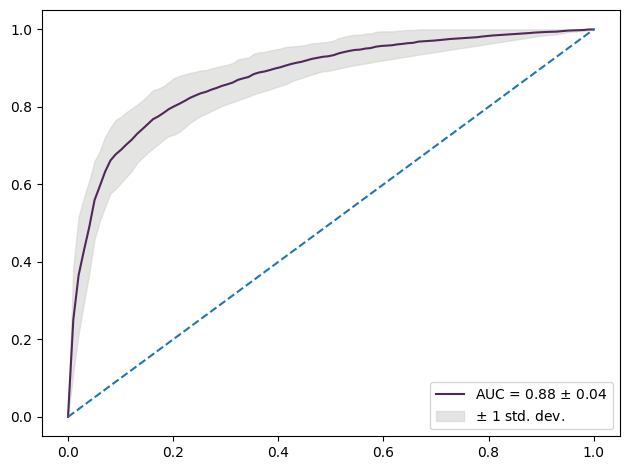

In [93]:
from sklearn import metrics
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

aucs = []
tprs = []
mean_fpr = np.linspace(0,1,100)
for i in range(5):
    test = pd.read_csv("test_set_pred_morgan_{}.csv".format(i))
    fpr, tpr, _ = metrics.roc_curve(test[BIN],test["proba1"])
    roc_auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
        mean_fpr,
        mean_tpr,
        color="#50285a",
        label=r"AUC = %0.2f $\pm$ %0.2f" % (mean_auc, std_auc),
    )
ax.plot([0, 1], [0, 1], ls="--")
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="#d2d2d0",
    alpha=0.6,
    label=r"$\pm$ 1 std. dev.",
    )
ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        )
ax.legend(loc="lower right")
ax.set_xlabel="1-Specificity (FPR)",
ax.set_ylabel="Sensitivity (TPR)",
plt.tight_layout()

## 8. Train an ML Model with Ersilia Compound Embeddings

In [94]:
import lazyqsar as lq

for i in range(5):
    train = pd.read_csv("train_set_{}.csv".format(i))
    test = pd.read_csv("test_set_{}.csv".format(i))
    smiles_train = train[SMILES]
    y_train = train[BIN]
    model = lq.ErsiliaBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(train[SMILES], train[BIN])
    y_hat = model.predict_proba(test[SMILES])
    test["proba1"] = y_hat[:,1]
    test.to_csv("test_set_pred_eosce_{}.csv".format(i))

[flaml.automl.logger: 09-26 15:13:02] {1679} INFO - task = classification
[flaml.automl.logger: 09-26 15:13:02] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 09-26 15:13:02] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 09-26 15:13:02] {1900} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost']
[flaml.automl.logger: 09-26 15:13:02] {2218} INFO - iteration 0, current learner rf
[flaml.automl.logger: 09-26 15:13:03] {2344} INFO - Estimated sufficient time budget=4433s. Estimated necessary time budget=4s.
[flaml.automl.logger: 09-26 15:13:03] {2391} INFO -  at 0.5s,	estimator rf's best error=0.3084,	best estimator rf's best error=0.3084
[flaml.automl.logger: 09-26 15:13:03] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 09-26 15:13:05] {2391} INFO -  at 3.1s,	estimator lgbm's best error=0.2859,	best estimator lgbm's best error=0.2859
[flaml.automl.logger: 09-26 15:13:05] {2218} INFO - iteration 2, current lear

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:13:06] {2391} INFO -  at 4.1s,	estimator xgboost's best error=0.2723,	best estimator xgboost's best error=0.2723
[flaml.automl.logger: 09-26 15:13:06] {2218} INFO - iteration 3, current learner rf
[flaml.automl.logger: 09-26 15:13:06] {2391} INFO -  at 4.4s,	estimator rf's best error=0.3084,	best estimator xgboost's best error=0.2723
[flaml.automl.logger: 09-26 15:13:06] {2218} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 09-26 15:13:08] {2391} INFO -  at 5.8s,	estimator lgbm's best error=0.2859,	best estimator xgboost's best error=0.2723
[flaml.automl.logger: 09-26 15:13:08] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 09-26 15:13:08] {2391} INFO -  at 6.0s,	estimator rf's best error=0.3019,	best estimator xgboost's best error=0.2723
[flaml.automl.logger: 09-26 15:13:08] {2218} INFO - iteration 6, current learner lgbm
[flaml.automl.logger: 09-26 15:13:09] {2391} INFO -  at 7.2s,	estimator lgbm's best error=0.2859,

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:13:14] {2391} INFO -  at 12.5s,	estimator xgboost's best error=0.2723,	best estimator lgbm's best error=0.2408
[flaml.automl.logger: 09-26 15:13:15] {2218} INFO - iteration 11, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:13:17] {2391} INFO -  at 14.6s,	estimator xgboost's best error=0.2626,	best estimator lgbm's best error=0.2408
[flaml.automl.logger: 09-26 15:13:17] {2218} INFO - iteration 12, current learner lgbm
[flaml.automl.logger: 09-26 15:13:20] {2391} INFO -  at 18.1s,	estimator lgbm's best error=0.2408,	best estimator lgbm's best error=0.2408
[flaml.automl.logger: 09-26 15:13:20] {2218} INFO - iteration 13, current learner lgbm
[flaml.automl.logger: 09-26 15:13:22] {2391} INFO -  at 19.7s,	estimator lgbm's best error=0.2408,	best estimator lgbm's best error=0.2408
[flaml.automl.logger: 09-26 15:13:22] {2218} INFO - iteration 14, current learner lgbm
[flaml.automl.logger: 09-26 15:13:25] {2391} INFO -  at 22.8s,	estimator lgbm's best error=0.2204,	best estimator lgbm's best error=0.2204
[flaml.automl.logger: 09-26 15:13:25] {2218} INFO - iteration 15, current learner rf
[flaml.automl.logger: 09-26 15:13:25] {2391} INFO -  at 23.3s,	estimator rf's best error=0.3019

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:13:26] {2391} INFO -  at 24.4s,	estimator xgboost's best error=0.2626,	best estimator lgbm's best error=0.2204
[flaml.automl.logger: 09-26 15:13:26] {2218} INFO - iteration 17, current learner rf
[flaml.automl.logger: 09-26 15:13:27] {2391} INFO -  at 25.0s,	estimator rf's best error=0.2801,	best estimator lgbm's best error=0.2204
[flaml.automl.logger: 09-26 15:13:27] {2218} INFO - iteration 18, current learner lgbm
[flaml.automl.logger: 09-26 15:13:29] {2391} INFO -  at 27.1s,	estimator lgbm's best error=0.2204,	best estimator lgbm's best error=0.2204
[flaml.automl.logger: 09-26 15:13:29] {2218} INFO - iteration 19, current learner rf
[flaml.automl.logger: 09-26 15:13:29] {2391} INFO -  at 27.3s,	estimator rf's best error=0.2612,	best estimator lgbm's best error=0.2204
[flaml.automl.logger: 09-26 15:13:29] {2218} INFO - iteration 20, current learner rf
[flaml.automl.logger: 09-26 15:13:31] {2391} INFO -  at 29.1s,	estimator rf's best error=0.2612,	best e

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:13:56] {2391} INFO -  at 54.2s,	estimator xgboost's best error=0.2626,	best estimator lgbm's best error=0.1731
[flaml.automl.logger: 09-26 15:13:56] {2218} INFO - iteration 25, current learner rf
[flaml.automl.logger: 09-26 15:13:57] {2391} INFO -  at 54.6s,	estimator rf's best error=0.2525,	best estimator lgbm's best error=0.1731
[flaml.automl.logger: 09-26 15:13:57] {2218} INFO - iteration 26, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:13:58] {2391} INFO -  at 55.6s,	estimator xgboost's best error=0.2626,	best estimator lgbm's best error=0.1731
[flaml.automl.logger: 09-26 15:13:58] {2218} INFO - iteration 27, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:14:01] {2391} INFO -  at 58.8s,	estimator xgboost's best error=0.2484,	best estimator lgbm's best error=0.1731
[flaml.automl.logger: 09-26 15:14:01] {2218} INFO - iteration 28, current learner rf
[flaml.automl.logger: 09-26 15:14:01] {2391} INFO -  at 59.3s,	estimator rf's best error=0.2525,	best estimator lgbm's best error=0.1731
[flaml.automl.logger: 09-26 15:14:01] {2218} INFO - iteration 29, current learner rf
[flaml.automl.logger: 09-26 15:14:02] {2391} INFO -  at 60.2s,	estimator rf's best error=0.2525,	best estimator lgbm's best error=0.1731
[flaml.automl.logger: 09-26 15:14:24] {2627} INFO - retrain lgbm for 22.0s
[flaml.automl.logger: 09-26 15:14:24] {2630} INFO - retrained model: LGBMClassifier(colsample_bytree=0.763007791741338,
               learning_rate=0.06217967145850895, max_bin=1023,
               min_child_samples=9, n_estimators=1, n_jobs=-1, num_leaves=14,
               reg_alpha=0.0009765625, reg_lambda=0.07358012736620588,
      

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:14:36] {2391} INFO -  at 2.5s,	estimator xgboost's best error=0.3090,	best estimator lgbm's best error=0.3024
[flaml.automl.logger: 09-26 15:14:36] {2218} INFO - iteration 3, current learner rf
[flaml.automl.logger: 09-26 15:14:36] {2391} INFO -  at 2.7s,	estimator rf's best error=0.3074,	best estimator lgbm's best error=0.3024
[flaml.automl.logger: 09-26 15:14:36] {2218} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 09-26 15:14:37] {2391} INFO -  at 4.2s,	estimator lgbm's best error=0.3011,	best estimator lgbm's best error=0.3011
[flaml.automl.logger: 09-26 15:14:37] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 09-26 15:14:37] {2391} INFO -  at 4.3s,	estimator rf's best error=0.3074,	best estimator lgbm's best error=0.3011
[flaml.automl.logger: 09-26 15:14:37] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 09-26 15:14:38] {2391} INFO -  at 5.0s,	estimator rf's best error=0.2957,	best estimator 

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:14:45] {2391} INFO -  at 11.9s,	estimator xgboost's best error=0.3019,	best estimator rf's best error=0.2526
[flaml.automl.logger: 09-26 15:14:45] {2218} INFO - iteration 12, current learner rf
[flaml.automl.logger: 09-26 15:14:46] {2391} INFO -  at 12.9s,	estimator rf's best error=0.2526,	best estimator rf's best error=0.2526
[flaml.automl.logger: 09-26 15:14:46] {2218} INFO - iteration 13, current learner rf
[flaml.automl.logger: 09-26 15:14:47] {2391} INFO -  at 14.2s,	estimator rf's best error=0.2526,	best estimator rf's best error=0.2526
[flaml.automl.logger: 09-26 15:14:47] {2218} INFO - iteration 14, current learner rf
[flaml.automl.logger: 09-26 15:14:49] {2391} INFO -  at 15.5s,	estimator rf's best error=0.2160,	best estimator rf's best error=0.2160
[flaml.automl.logger: 09-26 15:14:49] {2218} INFO - iteration 15, current learner rf
[flaml.automl.logger: 09-26 15:14:50] {2391} INFO -  at 16.7s,	estimator rf's best error=0.2160,	best estimator rf'

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:15:51] {2391} INFO -  at 2.7s,	estimator xgboost's best error=0.3108,	best estimator lgbm's best error=0.3022
[flaml.automl.logger: 09-26 15:15:51] {2218} INFO - iteration 3, current learner rf
[flaml.automl.logger: 09-26 15:15:52] {2391} INFO -  at 2.9s,	estimator rf's best error=0.3193,	best estimator lgbm's best error=0.3022
[flaml.automl.logger: 09-26 15:15:52] {2218} INFO - iteration 4, current learner rf
[flaml.automl.logger: 09-26 15:15:52] {2391} INFO -  at 3.2s,	estimator rf's best error=0.3193,	best estimator lgbm's best error=0.3022
[flaml.automl.logger: 09-26 15:15:52] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 09-26 15:15:52] {2391} INFO -  at 3.6s,	estimator rf's best error=0.3096,	best estimator lgbm's best error=0.3022
[flaml.automl.logger: 09-26 15:15:52] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 09-26 15:15:53] {2391} INFO -  at 3.9s,	estimator rf's best error=0.3096,	best estimator lgbm

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:15:59] {2391} INFO -  at 10.7s,	estimator xgboost's best error=0.3108,	best estimator lgbm's best error=0.2998
[flaml.automl.logger: 09-26 15:15:59] {2218} INFO - iteration 12, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:16:01] {2391} INFO -  at 12.1s,	estimator xgboost's best error=0.2961,	best estimator xgboost's best error=0.2961
[flaml.automl.logger: 09-26 15:16:01] {2218} INFO - iteration 13, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:16:02] {2391} INFO -  at 13.1s,	estimator xgboost's best error=0.2580,	best estimator xgboost's best error=0.2580
[flaml.automl.logger: 09-26 15:16:02] {2218} INFO - iteration 14, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:16:03] {2391} INFO -  at 14.3s,	estimator xgboost's best error=0.2580,	best estimator xgboost's best error=0.2580
[flaml.automl.logger: 09-26 15:16:03] {2218} INFO - iteration 15, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:16:04] {2391} INFO -  at 15.3s,	estimator xgboost's best error=0.2580,	best estimator xgboost's best error=0.2580
[flaml.automl.logger: 09-26 15:16:04] {2218} INFO - iteration 16, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:16:05] {2391} INFO -  at 16.7s,	estimator xgboost's best error=0.2439,	best estimator xgboost's best error=0.2439
[flaml.automl.logger: 09-26 15:16:05] {2218} INFO - iteration 17, current learner lgbm
[flaml.automl.logger: 09-26 15:16:07] {2391} INFO -  at 18.3s,	estimator lgbm's best error=0.2445,	best estimator xgboost's best error=0.2439
[flaml.automl.logger: 09-26 15:16:07] {2218} INFO - iteration 18, current learner lgbm
[flaml.automl.logger: 09-26 15:16:08] {2391} INFO -  at 19.4s,	estimator lgbm's best error=0.2445,	best estimator xgboost's best error=0.2439
[flaml.automl.logger: 09-26 15:16:08] {2218} INFO - iteration 19, current learner lgbm
[flaml.automl.logger: 09-26 15:16:10] {2391} INFO -  at 20.9s,	estimator lgbm's best error=0.2445,	best estimator xgboost's best error=0.2439
[flaml.automl.logger: 09-26 15:16:10] {2218} INFO - iteration 20, current learner lgbm
[flaml.automl.logger: 09-26 15:16:15] {2391} INFO -  at 25.9s,	estimator lgbm's b

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:16:21] {2391} INFO -  at 32.0s,	estimator xgboost's best error=0.2439,	best estimator lgbm's best error=0.2139
[flaml.automl.logger: 09-26 15:16:21] {2218} INFO - iteration 24, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:16:22] {2391} INFO -  at 33.2s,	estimator xgboost's best error=0.2439,	best estimator lgbm's best error=0.2139
[flaml.automl.logger: 09-26 15:16:22] {2218} INFO - iteration 25, current learner lgbm
[flaml.automl.logger: 09-26 15:16:24] {2391} INFO -  at 35.2s,	estimator lgbm's best error=0.2139,	best estimator lgbm's best error=0.2139
[flaml.automl.logger: 09-26 15:16:24] {2218} INFO - iteration 26, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:16:29] {2391} INFO -  at 40.0s,	estimator xgboost's best error=0.2062,	best estimator xgboost's best error=0.2062
[flaml.automl.logger: 09-26 15:16:29] {2218} INFO - iteration 27, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:16:30] {2391} INFO -  at 41.3s,	estimator xgboost's best error=0.2062,	best estimator xgboost's best error=0.2062
[flaml.automl.logger: 09-26 15:16:30] {2218} INFO - iteration 28, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:16:31] {2391} INFO -  at 42.7s,	estimator xgboost's best error=0.2062,	best estimator xgboost's best error=0.2062
[flaml.automl.logger: 09-26 15:16:31] {2218} INFO - iteration 29, current learner lgbm
[flaml.automl.logger: 09-26 15:16:47] {2391} INFO -  at 58.5s,	estimator lgbm's best error=0.1820,	best estimator lgbm's best error=0.1820
[flaml.automl.logger: 09-26 15:16:47] {2218} INFO - iteration 30, current learner rf
[flaml.automl.logger: 09-26 15:16:48] {2391} INFO -  at 59.1s,	estimator rf's best error=0.3000,	best estimator lgbm's best error=0.1820
[flaml.automl.logger: 09-26 15:16:48] {2218} INFO - iteration 31, current learner rf
[flaml.automl.logger: 09-26 15:16:48] {2391} INFO -  at 59.3s,	estimator rf's best error=0.3000,	best estimator lgbm's best error=0.1820
[flaml.automl.logger: 09-26 15:16:48] {2218} INFO - iteration 32, current learner rf
[flaml.automl.logger: 09-26 15:16:49] {2391} INFO -  at 60.0s,	estimator rf's best error=0.3000,	bes

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:17:25] {2391} INFO -  at 5.0s,	estimator xgboost's best error=0.3503,	best estimator xgboost's best error=0.3503
[flaml.automl.logger: 09-26 15:17:25] {2218} INFO - iteration 3, current learner rf
[flaml.automl.logger: 09-26 15:17:25] {2391} INFO -  at 5.2s,	estimator rf's best error=0.3757,	best estimator xgboost's best error=0.3503
[flaml.automl.logger: 09-26 15:17:25] {2218} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 09-26 15:17:26] {2391} INFO -  at 6.5s,	estimator lgbm's best error=0.3530,	best estimator xgboost's best error=0.3503
[flaml.automl.logger: 09-26 15:17:26] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 09-26 15:17:26] {2391} INFO -  at 6.7s,	estimator rf's best error=0.3517,	best estimator xgboost's best error=0.3503
[flaml.automl.logger: 09-26 15:17:26] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 09-26 15:17:27] {2391} INFO -  at 7.2s,	estimator rf's best error=0.3517,	bes

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:17:32] {2391} INFO -  at 12.0s,	estimator xgboost's best error=0.3503,	best estimator rf's best error=0.2514
[flaml.automl.logger: 09-26 15:17:32] {2218} INFO - iteration 15, current learner rf
[flaml.automl.logger: 09-26 15:17:32] {2391} INFO -  at 12.5s,	estimator rf's best error=0.2514,	best estimator rf's best error=0.2514
[flaml.automl.logger: 09-26 15:17:32] {2218} INFO - iteration 16, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:17:33] {2391} INFO -  at 13.5s,	estimator xgboost's best error=0.3442,	best estimator rf's best error=0.2514
[flaml.automl.logger: 09-26 15:17:33] {2218} INFO - iteration 17, current learner rf
[flaml.automl.logger: 09-26 15:17:36] {2391} INFO -  at 16.7s,	estimator rf's best error=0.2104,	best estimator rf's best error=0.2104
[flaml.automl.logger: 09-26 15:17:36] {2218} INFO - iteration 18, current learner rf
[flaml.automl.logger: 09-26 15:17:39] {2391} INFO -  at 19.4s,	estimator rf's best error=0.2104,	best estimator rf's best error=0.2104
[flaml.automl.logger: 09-26 15:17:39] {2218} INFO - iteration 19, current learner rf
[flaml.automl.logger: 09-26 15:17:42] {2391} INFO -  at 22.2s,	estimator rf's best error=0.2104,	best estimator rf's best error=0.2104
[flaml.automl.logger: 09-26 15:17:42] {2218} INFO - iteration 20, current learner rf
[flaml.automl.logger: 09-26 15:17:44] {2391} INFO -  at 24.8s,	estimator rf's best error=0.2050,	best estimator rf'

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:17:55] {2391} INFO -  at 35.1s,	estimator xgboost's best error=0.3013,	best estimator rf's best error=0.2006
[flaml.automl.logger: 09-26 15:17:55] {2218} INFO - iteration 25, current learner rf
[flaml.automl.logger: 09-26 15:18:03] {2391} INFO -  at 43.6s,	estimator rf's best error=0.1998,	best estimator rf's best error=0.1998
[flaml.automl.logger: 09-26 15:18:03] {2218} INFO - iteration 26, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:18:06] {2391} INFO -  at 46.0s,	estimator xgboost's best error=0.3013,	best estimator rf's best error=0.1998
[flaml.automl.logger: 09-26 15:18:06] {2218} INFO - iteration 27, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:18:08] {2391} INFO -  at 48.2s,	estimator xgboost's best error=0.3013,	best estimator rf's best error=0.1998
[flaml.automl.logger: 09-26 15:18:08] {2218} INFO - iteration 28, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:18:10] {2391} INFO -  at 49.9s,	estimator xgboost's best error=0.2698,	best estimator rf's best error=0.1998
[flaml.automl.logger: 09-26 15:18:10] {2218} INFO - iteration 29, current learner rf
[flaml.automl.logger: 09-26 15:18:16] {2391} INFO -  at 56.2s,	estimator rf's best error=0.1922,	best estimator rf's best error=0.1922
[flaml.automl.logger: 09-26 15:18:16] {2218} INFO - iteration 30, current learner lgbm
[flaml.automl.logger: 09-26 15:18:17] {2391} INFO -  at 57.4s,	estimator lgbm's best error=0.3530,	best estimator rf's best error=0.1922
[flaml.automl.logger: 09-26 15:18:17] {2218} INFO - iteration 31, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:18:19] {2391} INFO -  at 58.9s,	estimator xgboost's best error=0.2698,	best estimator rf's best error=0.1922
[flaml.automl.logger: 09-26 15:18:28] {2627} INFO - retrain rf for 9.5s
[flaml.automl.logger: 09-26 15:18:28] {2630} INFO - retrained model: RandomForestClassifier(criterion='entropy', max_features=0.08239152143485592,
                       max_leaf_nodes=78, n_estimators=21, n_jobs=-1,
                       random_state=12032022)
[flaml.automl.logger: 09-26 15:18:28] {1930} INFO - fit succeeded
[flaml.automl.logger: 09-26 15:18:28] {1931} INFO - Time taken to find the best model: 56.23362922668457
[flaml.automl.logger: 09-26 15:18:41] {1679} INFO - task = classification
[flaml.automl.logger: 09-26 15:18:41] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 09-26 15:18:41] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 09-26 15:18:41] {1900} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost']
[

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:18:44] {2391} INFO -  at 2.6s,	estimator xgboost's best error=0.3198,	best estimator rf's best error=0.3163
[flaml.automl.logger: 09-26 15:18:44] {2218} INFO - iteration 3, current learner rf
[flaml.automl.logger: 09-26 15:18:44] {2391} INFO -  at 2.8s,	estimator rf's best error=0.3163,	best estimator rf's best error=0.3163
[flaml.automl.logger: 09-26 15:18:44] {2218} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 09-26 15:18:45] {2391} INFO -  at 4.1s,	estimator lgbm's best error=0.3260,	best estimator rf's best error=0.3163
[flaml.automl.logger: 09-26 15:18:45] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 09-26 15:18:45] {2391} INFO -  at 4.4s,	estimator rf's best error=0.3163,	best estimator rf's best error=0.3163
[flaml.automl.logger: 09-26 15:18:45] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 09-26 15:18:46] {2391} INFO -  at 4.8s,	estimator rf's best error=0.3163,	best estimator rf's bes

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:18:54] {2391} INFO -  at 12.9s,	estimator xgboost's best error=0.3198,	best estimator lgbm's best error=0.2882
[flaml.automl.logger: 09-26 15:18:54] {2218} INFO - iteration 13, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:18:55] {2391} INFO -  at 14.0s,	estimator xgboost's best error=0.3116,	best estimator lgbm's best error=0.2882
[flaml.automl.logger: 09-26 15:18:55] {2218} INFO - iteration 14, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:18:56] {2391} INFO -  at 15.0s,	estimator xgboost's best error=0.3108,	best estimator lgbm's best error=0.2882
[flaml.automl.logger: 09-26 15:18:56] {2218} INFO - iteration 15, current learner lgbm
[flaml.automl.logger: 09-26 15:18:58] {2391} INFO -  at 16.7s,	estimator lgbm's best error=0.2553,	best estimator lgbm's best error=0.2553
[flaml.automl.logger: 09-26 15:18:58] {2218} INFO - iteration 16, current learner lgbm
[flaml.automl.logger: 09-26 15:19:00] {2391} INFO -  at 18.7s,	estimator lgbm's best error=0.2553,	best estimator lgbm's best error=0.2553
[flaml.automl.logger: 09-26 15:19:00] {2218} INFO - iteration 17, current learner lgbm
[flaml.automl.logger: 09-26 15:19:01] {2391} INFO -  at 20.1s,	estimator lgbm's best error=0.2553,	best estimator lgbm's best error=0.2553
[flaml.automl.logger: 09-26 15:19:01] {2218} INFO - iteration 18, current learner lgbm
[flaml.automl.logger: 09-26 15:19:07] {2391} INFO -  at 26.1s,	estimator lgbm's best error=0.

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:19:34] {2391} INFO -  at 52.9s,	estimator xgboost's best error=0.2911,	best estimator lgbm's best error=0.1623
[flaml.automl.logger: 09-26 15:19:34] {2218} INFO - iteration 25, current learner rf
[flaml.automl.logger: 09-26 15:19:35] {2391} INFO -  at 54.3s,	estimator rf's best error=0.2924,	best estimator lgbm's best error=0.1623
[flaml.automl.logger: 09-26 15:19:35] {2218} INFO - iteration 26, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:19:37] {2391} INFO -  at 55.6s,	estimator xgboost's best error=0.2911,	best estimator lgbm's best error=0.1623
[flaml.automl.logger: 09-26 15:19:37] {2218} INFO - iteration 27, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:19:38] {2391} INFO -  at 57.4s,	estimator xgboost's best error=0.2533,	best estimator lgbm's best error=0.1623
[flaml.automl.logger: 09-26 15:19:38] {2218} INFO - iteration 28, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:19:40] {2391} INFO -  at 59.2s,	estimator xgboost's best error=0.2487,	best estimator lgbm's best error=0.1623
[flaml.automl.logger: 09-26 15:19:56] {2627} INFO - retrain lgbm for 15.4s
[flaml.automl.logger: 09-26 15:19:56] {2630} INFO - retrained model: LGBMClassifier(colsample_bytree=0.6707317427642994,
               learning_rate=0.5126289195450011, max_bin=1023,
               min_child_samples=7, n_estimators=1, n_jobs=-1, num_leaves=20,
               reg_alpha=0.0009765625, reg_lambda=0.004594427837410769,
               verbose=-1)
[flaml.automl.logger: 09-26 15:19:56] {1930} INFO - fit succeeded
[flaml.automl.logger: 09-26 15:19:56] {1931} INFO - Time taken to find the best model: 48.0607476234436


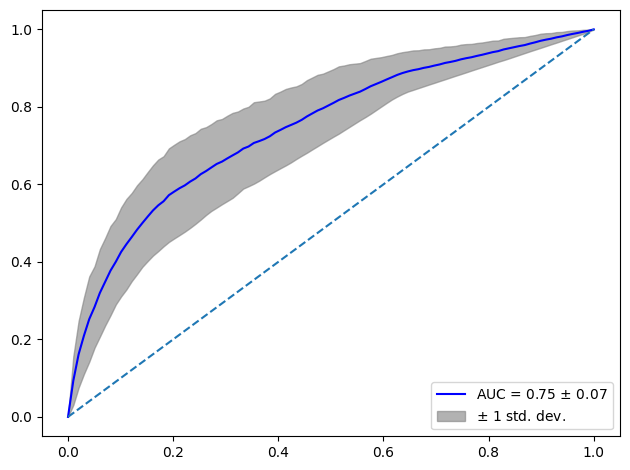

In [95]:
from sklearn import metrics
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

aucs = []
tprs = []
mean_fpr = np.linspace(0,1,100)
for i in range(5):
    test = pd.read_csv("test_set_pred_eosce_{}.csv".format(i))
    fpr, tpr, _ = metrics.roc_curve(test[BIN],test["proba1"])
    roc_auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
        mean_fpr,
        mean_tpr,
        color="blue",
        label=r"AUC = %0.2f $\pm$ %0.2f" % (mean_auc, std_auc),
    )
ax.plot([0, 1], [0, 1], ls="--")
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="gray",
    alpha=0.6,
    label=r"$\pm$ 1 std. dev.",
    )
ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        )
ax.legend(loc="lower right")
ax.set_xlabel="1-Specificity (FPR)",
ax.set_ylabel="Sensitivity (TPR)",
plt.tight_layout()

## 9. Save the final model

To ensure we use all possible data, at the end of the pipeline we will train the model with the whole dataset (train and test) and save it as the final model for deployment.

We need to choose which descriptor and parameters will work better for our case and build the model accordingly. We obtain that from the best train-test experiment.

In [98]:
# train the model with the full data

# load the whole dataset

df = pd.read_csv(filename)

# binarize the activity if needed
SMILES = "SMILES"
EXP = "pIC50"
BIN = "bin"

direction = "higher"
cutoff = 7

if direction == "lower":
    df[BIN] = [1 if x <= cutoff else 0 for x in df[EXP]]
elif direction == "higher":
    df[BIN] = [1 if x >= cutoff else 0 for x in df[EXP]]
else:
    print("no direction specified. Please select lower or higher direction for the activity cut-off")

# train the selected model
import lazyqsar as lq
smiles_train = df[SMILES]
y_train = df[BIN]
model = lq.MorganBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
model.fit(smiles_train, y_train)
model.save("hdac1_model.joblib")

[flaml.automl.logger: 09-26 15:20:57] {1679} INFO - task = classification
[flaml.automl.logger: 09-26 15:20:57] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 09-26 15:20:58] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 09-26 15:20:58] {1900} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost']
[flaml.automl.logger: 09-26 15:20:58] {2218} INFO - iteration 0, current learner rf
[flaml.automl.logger: 09-26 15:20:58] {2344} INFO - Estimated sufficient time budget=933s. Estimated necessary time budget=1s.
[flaml.automl.logger: 09-26 15:20:58] {2391} INFO -  at 0.3s,	estimator rf's best error=0.3204,	best estimator rf's best error=0.3204
[flaml.automl.logger: 09-26 15:20:58] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 09-26 15:20:58] {2391} INFO -  at 0.8s,	estimator lgbm's best error=0.3234,	best estimator rf's best error=0.3204
[flaml.automl.logger: 09-26 15:20:58] {2218} INFO - iteration 2, current learner

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:20:59] {2391} INFO -  at 1.4s,	estimator xgboost's best error=0.3316,	best estimator rf's best error=0.3204
[flaml.automl.logger: 09-26 15:20:59] {2218} INFO - iteration 3, current learner rf
[flaml.automl.logger: 09-26 15:20:59] {2391} INFO -  at 1.5s,	estimator rf's best error=0.2760,	best estimator rf's best error=0.2760
[flaml.automl.logger: 09-26 15:20:59] {2218} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 09-26 15:20:59] {2391} INFO -  at 1.9s,	estimator lgbm's best error=0.3209,	best estimator rf's best error=0.2760
[flaml.automl.logger: 09-26 15:20:59] {2218} INFO - iteration 5, current learner rf
[flaml.automl.logger: 09-26 15:20:59] {2391} INFO -  at 2.0s,	estimator rf's best error=0.2760,	best estimator rf's best error=0.2760
[flaml.automl.logger: 09-26 15:20:59] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 09-26 15:21:00] {2391} INFO -  at 2.2s,	estimator rf's best error=0.2276,	best estimator rf's bes

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:21:01] {2391} INFO -  at 3.9s,	estimator xgboost's best error=0.3316,	best estimator rf's best error=0.1843
[flaml.automl.logger: 09-26 15:21:01] {2218} INFO - iteration 12, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:21:02] {2391} INFO -  at 4.5s,	estimator xgboost's best error=0.2649,	best estimator rf's best error=0.1843
[flaml.automl.logger: 09-26 15:21:02] {2218} INFO - iteration 13, current learner rf
[flaml.automl.logger: 09-26 15:21:02] {2391} INFO -  at 4.7s,	estimator rf's best error=0.1843,	best estimator rf's best error=0.1843
[flaml.automl.logger: 09-26 15:21:02] {2218} INFO - iteration 14, current learner rf
[flaml.automl.logger: 09-26 15:21:03] {2391} INFO -  at 5.1s,	estimator rf's best error=0.1843,	best estimator rf's best error=0.1843
[flaml.automl.logger: 09-26 15:21:03] {2218} INFO - iteration 15, current learner rf
[flaml.automl.logger: 09-26 15:21:03] {2391} INFO -  at 5.6s,	estimator rf's best error=0.1291,	best estimator rf's best error=0.1291
[flaml.automl.logger: 09-26 15:21:03] {2218} INFO - iteration 16, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:21:04] {2391} INFO -  at 6.2s,	estimator xgboost's best error=0.2215,	best estimator rf's best error=0.1291
[flaml.automl.logger: 09-26 15:21:04] {2218} INFO - iteration 17, current learner rf
[flaml.automl.logger: 09-26 15:21:04] {2391} INFO -  at 6.6s,	estimator rf's best error=0.1291,	best estimator rf's best error=0.1291
[flaml.automl.logger: 09-26 15:21:04] {2218} INFO - iteration 18, current learner rf
[flaml.automl.logger: 09-26 15:21:05] {2391} INFO -  at 7.7s,	estimator rf's best error=0.1108,	best estimator rf's best error=0.1108
[flaml.automl.logger: 09-26 15:21:05] {2218} INFO - iteration 19, current learner rf
[flaml.automl.logger: 09-26 15:21:06] {2391} INFO -  at 8.3s,	estimator rf's best error=0.1072,	best estimator rf's best error=0.1072
[flaml.automl.logger: 09-26 15:21:06] {2218} INFO - iteration 20, current learner rf
[flaml.automl.logger: 09-26 15:21:07] {2391} INFO -  at 9.4s,	estimator rf's best error=0.1072,	best estimator rf's bes

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:21:11] {2391} INFO -  at 13.2s,	estimator xgboost's best error=0.2167,	best estimator rf's best error=0.0994
[flaml.automl.logger: 09-26 15:21:11] {2218} INFO - iteration 24, current learner rf
[flaml.automl.logger: 09-26 15:21:11] {2391} INFO -  at 13.7s,	estimator rf's best error=0.0994,	best estimator rf's best error=0.0994
[flaml.automl.logger: 09-26 15:21:11] {2218} INFO - iteration 25, current learner rf
[flaml.automl.logger: 09-26 15:21:13] {2391} INFO -  at 15.2s,	estimator rf's best error=0.0926,	best estimator rf's best error=0.0926
[flaml.automl.logger: 09-26 15:21:13] {2218} INFO - iteration 26, current learner rf
[flaml.automl.logger: 09-26 15:21:15] {2391} INFO -  at 17.6s,	estimator rf's best error=0.0863,	best estimator rf's best error=0.0863
[flaml.automl.logger: 09-26 15:21:15] {2218} INFO - iteration 27, current learner rf
[flaml.automl.logger: 09-26 15:21:16] {2391} INFO -  at 18.8s,	estimator rf's best error=0.0863,	best estimator rf'

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:21:35] {2391} INFO -  at 37.8s,	estimator xgboost's best error=0.2167,	best estimator rf's best error=0.0863
[flaml.automl.logger: 09-26 15:21:35] {2218} INFO - iteration 36, current learner rf
[flaml.automl.logger: 09-26 15:21:42] {2391} INFO -  at 44.1s,	estimator rf's best error=0.0863,	best estimator rf's best error=0.0863
[flaml.automl.logger: 09-26 15:21:42] {2218} INFO - iteration 37, current learner rf
[flaml.automl.logger: 09-26 15:21:45] {2391} INFO -  at 47.5s,	estimator rf's best error=0.0863,	best estimator rf's best error=0.0863
[flaml.automl.logger: 09-26 15:21:45] {2218} INFO - iteration 38, current learner rf
[flaml.automl.logger: 09-26 15:21:49] {2391} INFO -  at 51.4s,	estimator rf's best error=0.0863,	best estimator rf's best error=0.0863
[flaml.automl.logger: 09-26 15:21:49] {2218} INFO - iteration 39, current learner rf
[flaml.automl.logger: 09-26 15:21:51] {2391} INFO -  at 53.3s,	estimator rf's best error=0.0863,	best estimator rf'

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-26 15:21:51] {2391} INFO -  at 54.1s,	estimator xgboost's best error=0.1349,	best estimator rf's best error=0.0863
[flaml.automl.logger: 09-26 15:21:51] {2218} INFO - iteration 41, current learner rf
[flaml.automl.logger: 09-26 15:21:58] {2391} INFO -  at 60.4s,	estimator rf's best error=0.0863,	best estimator rf's best error=0.0863
[flaml.automl.logger: 09-26 15:22:02] {2627} INFO - retrain rf for 3.7s
[flaml.automl.logger: 09-26 15:22:02] {2630} INFO - retrained model: RandomForestClassifier(criterion='entropy', max_features=0.11313781713537083,
                       max_leaf_nodes=101, n_estimators=19, n_jobs=-1,
                       random_state=12032022)
[flaml.automl.logger: 09-26 15:22:02] {1930} INFO - fit succeeded
[flaml.automl.logger: 09-26 15:22:02] {1931} INFO - Time taken to find the best model: 17.592624187469482
